In [1]:
import joblib
import math
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from nilearn.connectome.connectivity_matrices import sym_matrix_to_vec
from neuroginius.plotting import plot_matrix

from cogpred.utils.configuration import get_config
from cogpred.transformers import MatrixMasker

config = get_config()
conn_dir = config["connectivity_matrices"]

REFNET = "Default"
INTER = "Default"

sns.reset_defaults()

In [2]:
ATLAS = "schaefer200"
k = 3

import os
from cogpred.loading import make_training_data
from cogpred.utils.naming import make_run_path

matrices, metadata = make_training_data(conn_dir, ATLAS, k)
run_path = make_run_path(config["output_dir"], k=k, feat="fc", atlas=ATLAS, groupkfold=True, net=REFNET, inter=INTER)
os.makedirs(run_path, exist_ok=True)
metadata.to_csv(run_path / "metadata.csv")

Dropping 8 subjects because of lacking MMMSE


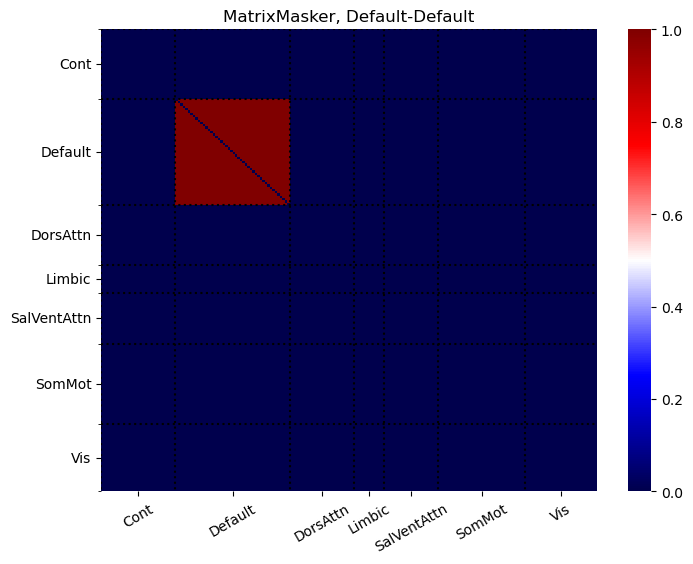

In [3]:
masker = MatrixMasker(REFNET, INTER).fit(matrices, metadata)

masker.fit(matrices).plot()
plt.show()

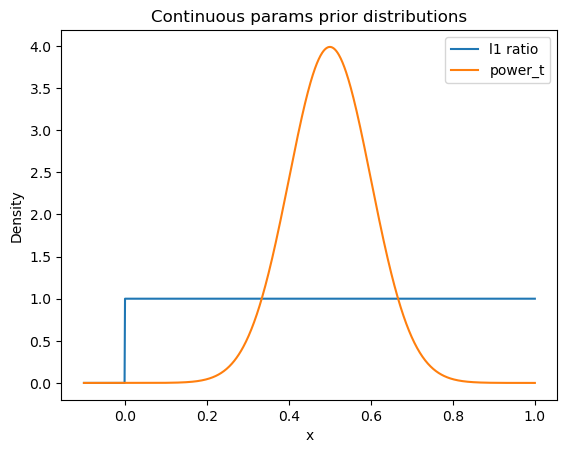

In [4]:
from scipy import stats

#lambda_param = 1 / 1e-4
lambda_param = 1000
alpha_distribution = stats.expon(scale=1/lambda_param)
l1_ratio = stats.uniform(0, 1)
#l1_ratio = stats.beta(1.5, 3) # TODO Try higher l1_ratio with high n_comps
#l1_ratio = stats.expon(scale=1/7)
power_t = stats.norm(loc=0.5, scale=0.1)

x = np.linspace(-0.1, 1, 1000)
da = alpha_distribution.pdf(x)
dl = l1_ratio.pdf(x)
dt = power_t.pdf(x)


#plt.plot(x, da, label="alpha")
plt.plot(x, dl, label="l1 ratio")
plt.plot(x, dt, label="power_t")
plt.title("Continuous params prior distributions")
plt.xlabel("x")
plt.ylabel("Density")
plt.legend()
plt.show()


In [5]:
param_dist = {
    "classifier__loss": ["hinge", "log_loss", "modified_huber"],
    "classifier__alpha": alpha_distribution,
    "classifier__l1_ratio": l1_ratio,
    "classifier__power_t": power_t,
    #"reduction__n_components": n_comps
}

In [6]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GroupShuffleSplit, train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn import preprocessing

from sklearn.decomposition import PCA
from sklearn.semi_supervised import SelfTrainingClassifier
from sklearn.metrics import f1_score
from functools import partial

from sklearn.model_selection import cross_val_predict, RandomizedSearchCV, cross_val_score, StratifiedGroupKFold
from cogpred.supervised import macro_f1

sgd = SGDClassifier(
    penalty="elasticnet",
    class_weight="balanced", 
    random_state=1999
)

clf = Pipeline(
    [
    ("matrixmasker", MatrixMasker(REFNET, INTER)),
    ("scaler", preprocessing.StandardScaler()),
    #("reduction", PCA()),
    ("classifier", sgd)
    ],
    verbose=False
)

inner_cv = StratifiedGroupKFold(n_splits=8, shuffle=True, random_state=1999)
outer_cv = StratifiedGroupKFold(n_splits=8, shuffle=True, random_state=1999)

search = RandomizedSearchCV(
    clf,
    param_distributions=param_dist,
    n_iter=100,
    scoring=macro_f1,
    cv=inner_cv,
    random_state=1999,
    verbose=1,
    n_jobs=8,
    error_score="raise"
)

In [7]:
y = metadata.cluster_label.values
search.fit(matrices, y, groups=metadata.CEN_ANOM.values)
cv_results = pd.DataFrame(search.cv_results_).sort_values(by="mean_test_score", ascending=False)
cv_results

Fitting 8 folds for each of 100 candidates, totalling 800 fits
________________________________________________________________________________
[Memory] Calling cogpred.transformers._transform...
_transform(array([[[ 0.996   , ...,  0.016052],
        ...,
        [ 0.016052, ...,  0.996   ]],

       ...,

       [[ 0.996   , ..., -0.01229 ],
        ...,
        [-0.01229 , ...,  0.996   ]]], dtype=float32), 
array([ 2774, ..., 19899]))
________________________________________________________________________________
[Memory] Calling cogpred.transformers._transform...
_transform(array([[[ 0.996   , ...,  0.016052],
        ...,
        [ 0.016052, ...,  0.996   ]],

       ...,

       [[ 0.996   , ..., -0.01229 ],
        ...,
        [-0.01229 , ...,  0.996   ]]], dtype=float32), 
array([ 2774, ..., 19899]))
________________________________________________________________________________
[Memory] Calling cogpred.transformers._transform...
_transform(array([[[ 0.996   , ...,  0.01605

/homes_unix/jlegrand/miniconda3/envs/cogpred/lib/python3.12/site-packages/sklearn/linear_model/_stochastic_gradient.py:744: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/homes_unix/jlegrand/miniconda3/envs/cogpred/lib/python3.12/site-packages/sklearn/linear_model/_stochastic_gradient.py:744: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/homes_unix/jlegrand/miniconda3/envs/cogpred/lib/python3.12/site-packages/sklearn/linear_model/_stochastic_gradient.py:744: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/homes_unix/jlegrand/miniconda3/envs/cogpred/lib/python3.12/site-packages/sklearn/linear_model/_stochastic_gradient.py:744: ConvergenceWarning: Maximum number of iteration reached before convergence. Co

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__alpha,param_classifier__l1_ratio,param_classifier__loss,param_classifier__power_t,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,mean_test_score,std_test_score,rank_test_score
67,1.176453,0.145964,0.051982,0.031142,0.000019,0.413347,log_loss,0.531562,"{'classifier__alpha': 1.8760892613954563e-05, ...",0.368878,0.590909,0.424528,0.393927,0.275856,0.303308,0.316730,0.370549,0.380586,0.091924,1
70,1.703450,0.324680,0.049472,0.028701,0.002282,0.834925,hinge,0.441116,"{'classifier__alpha': 0.002281727544430136, 'c...",0.334464,0.590909,0.438393,0.351340,0.333691,0.307002,0.376851,0.309542,0.380274,0.088906,2
76,2.205586,0.568848,0.049506,0.029210,0.001422,0.934562,modified_huber,0.480626,"{'classifier__alpha': 0.0014218255588621987, '...",0.396201,0.543396,0.424158,0.322385,0.323167,0.277815,0.348469,0.338387,0.371747,0.077527,3
13,1.016982,0.153564,0.050749,0.027212,0.000084,0.993549,hinge,0.620199,"{'classifier__alpha': 8.400384825507838e-05, '...",0.385367,0.496296,0.473469,0.371325,0.340321,0.275986,0.327687,0.298947,0.371175,0.073690,4
26,1.478709,0.280086,0.052868,0.027830,0.000801,0.829174,log_loss,0.637829,"{'classifier__alpha': 0.0008013551629935216, '...",0.371798,0.565432,0.317230,0.360290,0.331111,0.299571,0.356968,0.345868,0.368533,0.077688,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56,2.511604,0.662870,0.047869,0.028072,0.001805,0.920590,modified_huber,0.646551,"{'classifier__alpha': 0.001805223839408241, 'c...",0.384581,0.415385,0.296923,0.331904,0.320471,0.276989,0.346611,0.305003,0.334733,0.043287,96
98,1.557047,0.122754,0.055032,0.034727,0.004184,0.673848,hinge,0.400092,"{'classifier__alpha': 0.004184333345290324, 'c...",0.309834,0.417284,0.289562,0.345742,0.356167,0.309514,0.319247,0.315200,0.332819,0.037556,97
0,7.151686,1.461487,0.157316,0.067238,0.001740,0.984627,log_loss,0.587207,"{'classifier__alpha': 0.0017402311925260737, '...",0.394875,0.395722,0.276049,0.364033,0.285742,0.271099,0.334457,0.331075,0.331632,0.047467,98
68,3.532792,1.064288,0.049079,0.028618,0.000971,0.993877,log_loss,0.508933,"{'classifier__alpha': 0.0009713204162961679, '...",0.396593,0.397942,0.275737,0.339823,0.286581,0.272541,0.344975,0.325462,0.329957,0.046802,99


In [8]:
est = search.best_estimator_
reg = est.named_steps["classifier"]
masker = est.named_steps["matrixmasker"]
atlas = masker.atlas

In [9]:
def net_select(label):
    if label == masker.refnet:
        return 1
    return 0

regions = []
for region, network in zip(atlas.labels, atlas.macro_labels):
    if network == masker.refnet:
        regions.append(region)

# Hack to remove that annoying dtype thing from nilearn
regions = list(np.array(regions).astype(str))

n_regions = sum(map(net_select, atlas.macro_labels))

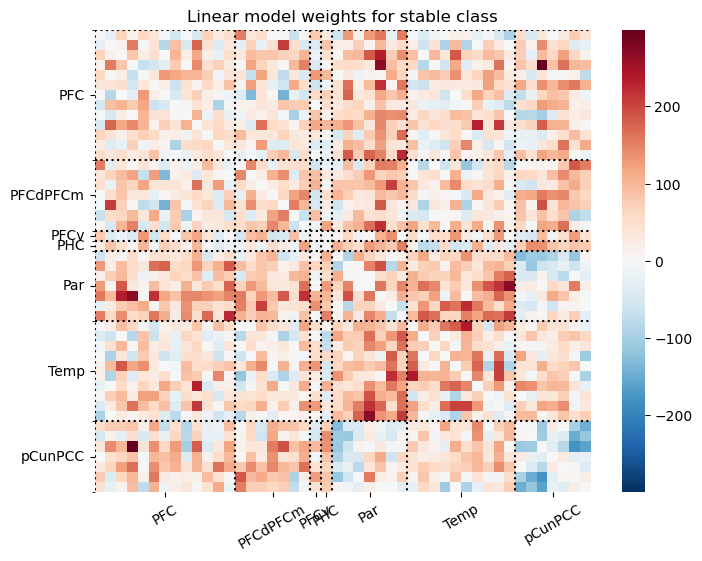

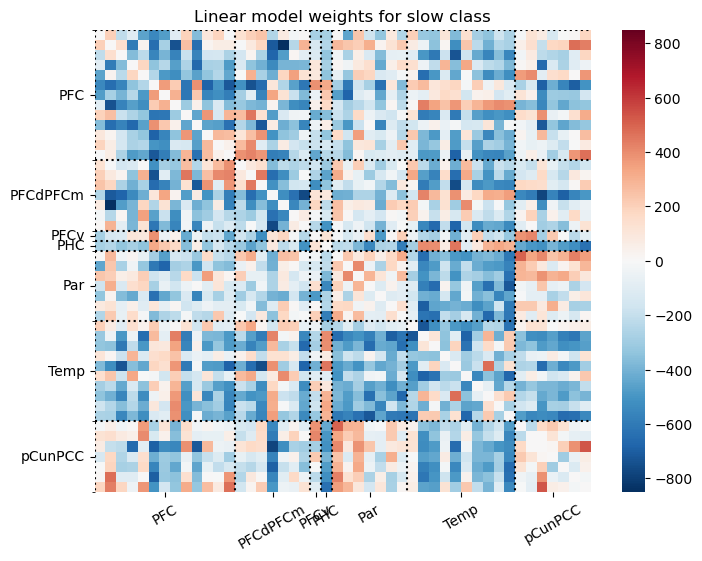

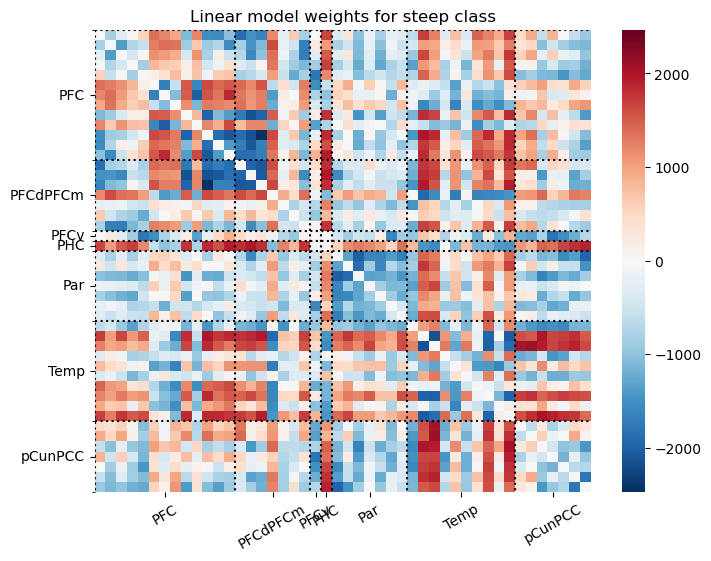

In [10]:
from nilearn.connectome import vec_to_sym_matrix
def region_split(label):
    return label.split("_")[-2]

class MockAtlas:
    macro_labels = list(map(region_split, regions))
    
# TODO What would happen if we inverse-transformed the coefs?
cats = ("stable", "slow", "steep")
for i in range(k):

    coefs = reg.coef_[i, :]

    # Perform Hauf transform to make coefs interpretable
    X = masker.transform(matrices)
    X = est.named_steps["scaler"].transform(X)
    patterns = np.cov(X.T) @ coefs

    arr = vec_to_sym_matrix(patterns, diagonal=np.zeros(n_regions))
    cat = cats[i]
    axes = plot_matrix(
        np.where(np.abs(arr) > 0, arr, 0),
        MockAtlas(),
        cmap="RdBu_r",
        #bounds=(-4, 4)
    )
    axes.set_title(f"Linear model weights for {cat} class")
    plt.show()

In [11]:
test_scores = cross_val_score(
    search,
    X,
    y,
    cv=outer_cv.split(X, y, groups=metadata.CEN_ANOM.values),
    n_jobs=8,
    scoring=macro_f1,
    verbose=1,
    fit_params={"groups": metadata.CEN_ANOM.values} # This is for inner cv
)
test_scores

/homes_unix/jlegrand/miniconda3/envs/cogpred/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 8 folds for each of 100 candidates, totalling 800 fits
Fitting 8 folds for each of 100 candidates, totalling 800 fits
Fitting 8 folds for each of 100 candidates, totalling 800 fits
Fitting 8 folds for each of 100 candidates, totalling 800 fits
Fitting 8 folds for each of 100 candidates, totalling 800 fits
Fitting 8 folds for each of 100 candidates, totalling 800 fits
Fitting 8 folds for each of 100 candidates, totalling 800 fits
Fitting 8 folds for each of 100 candidates, totalling 800 fits
________________________________________________________________________________
[Memory] Calling cogpred.transformers._transform...
_transform(array([[-1.833415, ..., -0.196023],
       ...,
       [-0.022012, ..., -1.12429 ]], dtype=float32), 
array([ 2774, ..., 19899]))
________________________________________________________________________________
[Memory] Calling cogpred.transformers._transform...
_transform(array([[-0.29769 , ..., -0.83356 ],
       ...,
       [-0.022012, ..., -1.124

[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.2s remaining:    0.7s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.3s finished


________________________________________________________________________________
[Memory] Calling cogpred.transformers._transform...
_transform(array([[ 1.386707, ..., -0.824525],
       ...,
       [-0.022012, ..., -1.12429 ]], dtype=float32), 
array([ 2774, ..., 19899]))
________________________________________________________________________________
[Memory] Calling cogpred.transformers._transform...
_transform(array([[-0.29769 , ..., -0.83356 ],
       ...,
       [-0.022012, ..., -1.12429 ]], dtype=float32), 
array([ 2774, ..., 19899]))________________________________________________________________________________
[Memory] Calling cogpred.transformers._transform...
_transform(array([[-0.29769 , ..., -0.83356 ],
       ...,
       [-0.022012, ..., -1.12429 ]], dtype=float32), 
array([ 2774, ..., 19899]))

________________________________________________________________________________
[Memory] Calling cogpred.transformers._transform...
_transform(array([[-0.29769 , ..., -0.83356 ]

ValueError: 
All the 8 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
8 fits failed with the following error:
joblib.externals.loky.process_executor._RemoteTraceback: 
"""
Traceback (most recent call last):
  File "/homes_unix/jlegrand/miniconda3/envs/cogpred/lib/python3.12/site-packages/joblib/_utils.py", line 72, in __call__
    return self.func(**kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/homes_unix/jlegrand/miniconda3/envs/cogpred/lib/python3.12/site-packages/joblib/parallel.py", line 598, in __call__
    return [func(*args, **kwargs)
            ^^^^^^^^^^^^^^^^^^^^^
  File "/homes_unix/jlegrand/miniconda3/envs/cogpred/lib/python3.12/site-packages/sklearn/utils/parallel.py", line 129, in __call__
    return self.function(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/homes_unix/jlegrand/miniconda3/envs/cogpred/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/homes_unix/jlegrand/miniconda3/envs/cogpred/lib/python3.12/site-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/homes_unix/jlegrand/miniconda3/envs/cogpred/lib/python3.12/site-packages/sklearn/pipeline.py", line 472, in fit
    Xt = self._fit(X, y, routed_params)
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/homes_unix/jlegrand/miniconda3/envs/cogpred/lib/python3.12/site-packages/sklearn/pipeline.py", line 409, in _fit
    X, fitted_transformer = fit_transform_one_cached(
                            ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/homes_unix/jlegrand/miniconda3/envs/cogpred/lib/python3.12/site-packages/joblib/memory.py", line 312, in __call__
    return self.func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/homes_unix/jlegrand/miniconda3/envs/cogpred/lib/python3.12/site-packages/sklearn/pipeline.py", line 1329, in _fit_transform_one
    res = transformer.fit_transform(X, y, **params.get("fit_transform", {}))
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/homes_unix/jlegrand/miniconda3/envs/cogpred/lib/python3.12/site-packages/sklearn/utils/_set_output.py", line 313, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/homes_unix/jlegrand/miniconda3/envs/cogpred/lib/python3.12/site-packages/sklearn/base.py", line 1101, in fit_transform
    return self.fit(X, y, **fit_params).transform(X)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/homes_unix/jlegrand/miniconda3/envs/cogpred/lib/python3.12/site-packages/sklearn/utils/_set_output.py", line 313, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/bigdata/jlegrand/cogpred/cogpred/transformers.py", line 44, in transform
    return _transform(matrices, self.vec_idx_)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/homes_unix/jlegrand/miniconda3/envs/cogpred/lib/python3.12/site-packages/joblib/memory.py", line 577, in __call__
    return self._cached_call(args, kwargs, shelving=False)[0]
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/homes_unix/jlegrand/miniconda3/envs/cogpred/lib/python3.12/site-packages/joblib/memory.py", line 532, in _cached_call
    return self._call(call_id, args, kwargs, shelving)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/homes_unix/jlegrand/miniconda3/envs/cogpred/lib/python3.12/site-packages/joblib/memory.py", line 771, in _call
    output = self.func(*args, **kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/bigdata/jlegrand/cogpred/cogpred/transformers.py", line 16, in _transform
    vec = sym_matrix_to_vec(mat, discard_diagonal=True)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/homes_unix/jlegrand/miniconda3/envs/cogpred/lib/python3.12/site-packages/nilearn/connectome/connectivity_matrices.py", line 241, in sym_matrix_to_vec
    return symmetric[..., tril_mask]
           ~~~~~~~~~^^^^^^^^^^^^^^^^
IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed
"""

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/homes_unix/jlegrand/miniconda3/envs/cogpred/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/homes_unix/jlegrand/miniconda3/envs/cogpred/lib/python3.12/site-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/homes_unix/jlegrand/miniconda3/envs/cogpred/lib/python3.12/site-packages/sklearn/model_selection/_search.py", line 968, in fit
    self._run_search(evaluate_candidates)
  File "/homes_unix/jlegrand/miniconda3/envs/cogpred/lib/python3.12/site-packages/sklearn/model_selection/_search.py", line 1930, in _run_search
    evaluate_candidates(
  File "/homes_unix/jlegrand/miniconda3/envs/cogpred/lib/python3.12/site-packages/sklearn/model_selection/_search.py", line 914, in evaluate_candidates
    out = parallel(
          ^^^^^^^^^
  File "/homes_unix/jlegrand/miniconda3/envs/cogpred/lib/python3.12/site-packages/sklearn/utils/parallel.py", line 67, in __call__
    return super().__call__(iterable_with_config)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/homes_unix/jlegrand/miniconda3/envs/cogpred/lib/python3.12/site-packages/joblib/parallel.py", line 2007, in __call__
    return output if self.return_generator else list(output)
                                                ^^^^^^^^^^^^
  File "/homes_unix/jlegrand/miniconda3/envs/cogpred/lib/python3.12/site-packages/joblib/parallel.py", line 1650, in _get_outputs
    yield from self._retrieve()
  File "/homes_unix/jlegrand/miniconda3/envs/cogpred/lib/python3.12/site-packages/joblib/parallel.py", line 1754, in _retrieve
    self._raise_error_fast()
  File "/homes_unix/jlegrand/miniconda3/envs/cogpred/lib/python3.12/site-packages/joblib/parallel.py", line 1789, in _raise_error_fast
    error_job.get_result(self.timeout)
  File "/homes_unix/jlegrand/miniconda3/envs/cogpred/lib/python3.12/site-packages/joblib/parallel.py", line 745, in get_result
    return self._return_or_raise()
           ^^^^^^^^^^^^^^^^^^^^^^^
  File "/homes_unix/jlegrand/miniconda3/envs/cogpred/lib/python3.12/site-packages/joblib/parallel.py", line 763, in _return_or_raise
    raise self._result
IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed


In [12]:
import joblib
cv_results.to_csv(run_path / "cv_results.csv")
joblib.dump(test_scores, run_path / "test_scores.joblib")
joblib.dump(search.best_estimator_, run_path / "best_estimator.joblib")

['/homes_unix/jlegrand/data/Memento/output/prediction/k-3_feat-fc_atlas-schaefer200_groupkfold-True_net-Default_inter-Default/best_estimator.joblib']